<a href="https://colab.research.google.com/github/AliyevaO/Loan/blob/main/Loan_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Oleksandra Aliyeva
* 03.12.2022

In [ ]:
#mount google disk
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import some necessary tools
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer

#import models for ML
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import  RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier

#import accuracy, precision, recall, classification report, and confusion matrix scoring functions
from sklearn.metrics import accuracy_score, get_scorer, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV 
from sklearn import metrics
from sklearn import set_config
set_config(display='diagram')

In [ ]:
#download data and check the head
loan_df = pd.read_csv('/content/drive/MyDrive/Bootcamp/Data/partial_loan_dataset.csv')
loan_df.head()

,Loan_ID,Gender,Married,Dependent_No,Education,Self_Employed,Applicant_Income,CoApplicant_Income,Loan_Amount,Loan_Amount_Term,Credit History,Property_District,Loan_Status
0,23002,Male,True,3,Graduate,True,4315,19748.0,60000,300,1,OCR,1
1,23003,Female,True,3,Not Graduate,True,3331,29657.0,20000,60,0,OCR,1
2,23004,Male,True,3,Not Graduate,True,22494,29539.0,30000,240,1,RCR,1
3,23005,Male,True,2,Not Graduate,False,78117,12909.0,20000,60,0,OCR,1
4,23006,Male,False,2,Not Graduate,False,41976,45598.0,60000,300,1,RCR,1


In [ ]:
#check general info
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Loan_ID             5584 non-null   int64  
 1   Gender              5425 non-null   object 
 2   Married             5328 non-null   object 
 3   Dependent_No        5584 non-null   int64  
 4   Education           5218 non-null   object 
 5   Self_Employed       5584 non-null   bool   
 6   Applicant_Income    5584 non-null   int64  
 7   CoApplicant_Income  4999 non-null   float64
 8   Loan_Amount         5584 non-null   int64  
 9   Loan_Amount_Term    5584 non-null   int64  
 10  Credit History      5584 non-null   int64  
 11  Property_District   5578 non-null   object 
 12  Loan_Status         5584 non-null   int64  
dtypes: bool(1), float64(1), int64(7), object(4)
memory usage: 529.1+ KB


## Cleaning Data

In [ ]:
#check for duplicates
loan_df.duplicated().sum()

0

* Data set doesn't have any duplicates.

In [ ]:
#change boolean columns type to str
loan_df['Self_Employed'] = loan_df['Self_Employed'].astype(str)

In [ ]:
#check for any inconsistencies
data_types = loan_df.dtypes
str_cols = data_types[data_types=='object'].index
str_cols

Index(['Gender', 'Married', 'Education', 'Self_Employed', 'Property_District'], dtype='object')

In [ ]:
#loop to iterate through all columns with dtype - object
for col in str_cols:
    print(f'- {col}:')
    print (loan_df[col].value_counts(dropna=False))
    print('\n------------------------')

- Gender:
Male      3655
Female    1770
NaN        159
Name: Gender, dtype: int64

------------------------
- Married:
False    2677
True     2651
NaN       256
Name: Married, dtype: int64

------------------------
- Education:
Not Graduate    3082
Graduate        2136
NaN              366
Name: Education, dtype: int64

------------------------
- Self_Employed:
True     3338
False    2246
Name: Self_Employed, dtype: int64

------------------------
- Property_District:
OCR    2797
RCR    1399
CCR    1382
NaN       6
Name: Property_District, dtype: int64

------------------------


* Data set doesn't have any inconsistente values.

In [ ]:
#check for missing values
loan_df.isnull().sum()

Loan_ID                 0
Gender                159
Married               256
Dependent_No            0
Education             366
Self_Employed           0
Applicant_Income        0
CoApplicant_Income    585
Loan_Amount             0
Loan_Amount_Term        0
Credit History          0
Property_District       6
Loan_Status             0
dtype: int64

* Data set has missing values in 5 columns.

In [ ]:
set_length = len(loan_df['Gender'])
gender_missing = loan_df['Gender'].isna().sum()
married_missing = loan_df['Married'].isna().sum()
education_missing = loan_df['Education'].isna().sum()
coap_inc_missing = loan_df['CoApplicant_Income'].isna().sum()
district_missing = loan_df['Property_District'].isna().sum()

In [ ]:
# print % of missind data in each column
print('Percentage of missing values by columns:')
print(f'Gender - {round((gender_missing/set_length)*100, 1)} %')
print(f'Married - {round((married_missing/set_length)*100, 1)} %')
print(f'Education - {round((education_missing/set_length)*100, 1)} %')
print(f'CoApplicant Income - {round((coap_inc_missing/set_length)*100, 1)} %')
print(f'Property District  - {round((district_missing/set_length)*100, 1)} %')

Percentage of missing values by columns:
Gender - 2.8 %
Married - 4.6 %
Education - 6.6 %
CoApplicant Income - 10.5 %
Property District  - 0.1 %


In [ ]:
#drop rows that have 3 or more NaN values
loan_df = loan_df[loan_df.isnull().sum(axis=1) < 3]

In [ ]:
#fill missing rows in Column 'Gender' with most frequent
loan_df['Gender'].fillna(loan_df['Gender'].mode()[0], inplace=True)

In [ ]:
#fill missing data in column 'Married' with 'Unknown'
married_missing = loan_df['Married'].fillna('Unknown')
loan_df['Married'].fillna(value=married_missing, inplace=True)

In [ ]:
#fill missing data in column 'Education' with 'Unknown'
education_missing = loan_df['Education'].fillna('Unknown')
loan_df['Education'].fillna(value=education_missing, inplace=True)

In [ ]:
#fill missing data in column 'Property_District' with most frequent
loan_df['Property_District'].fillna(loan_df['Property_District'].mode()[0], inplace=True)

In [ ]:
#fill missing data in column 'CoApplicant_Income' by grouping 'Gender', 'Credit History', 'Loan_Amount' and 'Property_District'
loan_df['CoApplicant_Income'] = loan_df.groupby(['Gender','Credit History','Loan_Amount','Property_District'])['CoApplicant_Income'].transform(lambda x: x.fillna(x.mean()))

* For columns 'Gender' and 'Property_District' I used a stategy of 'most frequent'. Columns 'Married'and 'Education' I filled with 'Unknown', I don't see any columns that can help me to fill it in a better way. Last column that I was filling was 'CoApplicant_Income' I used mean value of groupby columns 'Gender', 'Credit History', 'Loan_Amount' and 'Property_District'.  

In [ ]:
#change boolean columns type to str
loan_df['Married'] = loan_df['Married'].astype(str)

In [ ]:
#check for any missing values remain
loan_df.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependent_No          0
Education             0
Self_Employed         0
Applicant_Income      0
CoApplicant_Income    0
Loan_Amount           0
Loan_Amount_Term      0
Credit History        0
Property_District     0
Loan_Status           0
dtype: int64

In [ ]:
#check the summary statistics of each numerical columns 
loan_df.describe()

,Loan_ID,Dependent_No,Applicant_Income,CoApplicant_Income,Loan_Amount,Loan_Amount_Term,Credit History,Loan_Status
count,5576.000000,5576.000000,5576.000000,5576.000000,5576.000000,5576.000000,5576.000000,5576.000000
mean,25793.663917,1.995337,50645.244082,25365.415069,35335.365854,212.647059,0.663917,0.667145
std,1612.409405,1.414460,28573.516655,13440.094397,17150.208804,102.955891,0.472410,0.471277
min,23002.000000,0.000000,1002.000000,1002.000000,10000.000000,60.000000,0.000000,0.000000
25%,24396.750000,1.000000,26090.250000,14729.250000,20000.000000,120.000000,0.000000,0.000000
50%,25794.500000,2.000000,50905.000000,24968.886364,40000.000000,240.000000,1.000000,1.000000
75%,27189.250000,3.000000,75734.000000,36214.500000,50000.000000,300.000000,1.000000,1.000000
max,28585.000000,4.000000,99995.000000,49997.000000,60000.000000,360.000000,1.000000,1.000000


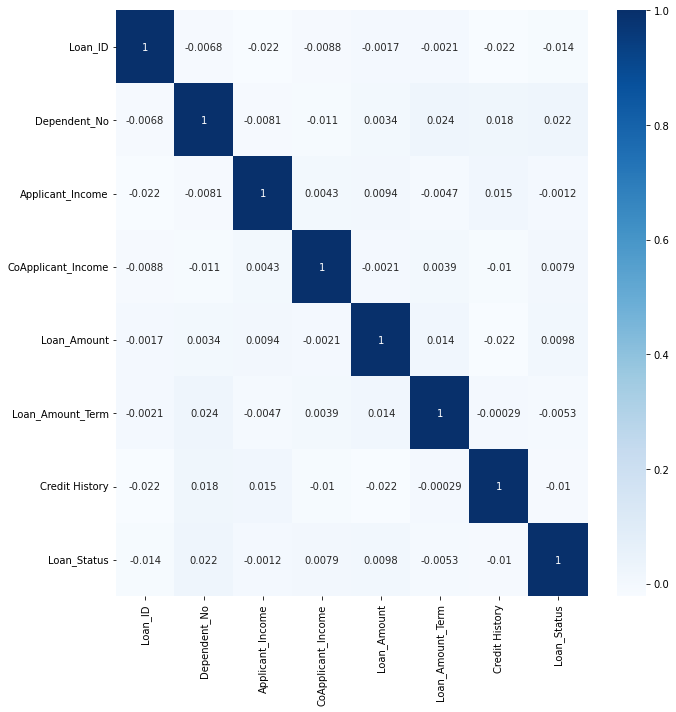

In [ ]:
#create a heatmap to see correlation
plt.figure(figsize=(10,10))
sns.heatmap(loan_df.corr(), cmap = 'Blues', annot = True)
plt.tight_layout()
plt.savefig('Heat map.png', dpi = 300);

* We can see that numerical columns of our Data set have weak correlation. 

## Visualization


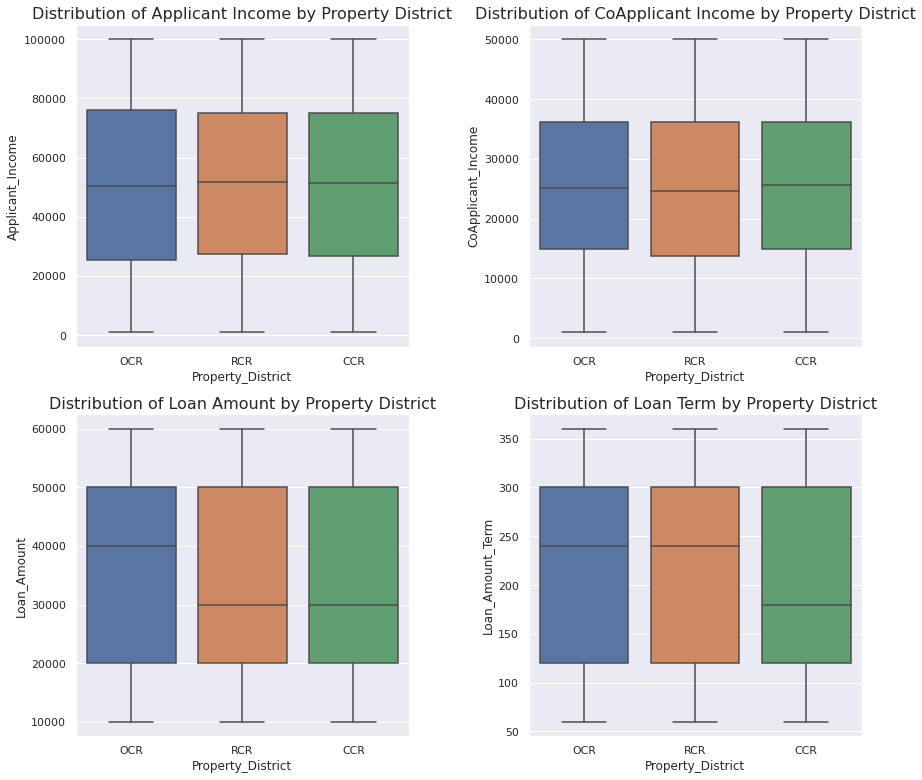

In [ ]:
#create a 4 boxplots describing Property_District
sns.set_theme()
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(13,11))
sns.set_color_codes("pastel")
ax = sns.boxplot(data=loan_df, x='Property_District', y='Applicant_Income', ax=axes[0,0] )
ax.set_title('Distribution of Applicant Income by Property District', fontsize=16)
ax2 = sns.boxplot(data=loan_df, x='Property_District', y='CoApplicant_Income',ax=axes[0,1]) 
ax2.set_title('Distribution of CoApplicant Income by Property District', fontsize=16)
ax3 = sns.boxplot(data=loan_df, x='Property_District', y='Loan_Amount', ax=axes[1,0]) 
ax3.set_title('Distribution of Loan Amount by Property District', fontsize=16)
ax4 = sns.boxplot(data=loan_df, x='Property_District', y='Loan_Amount_Term', ax=axes[1,1]) 
ax4.set_title('Distribution of Loan Term by Property District', fontsize=16)
fig.tight_layout()
plt.savefig('Distribution.png', dpi = 300);

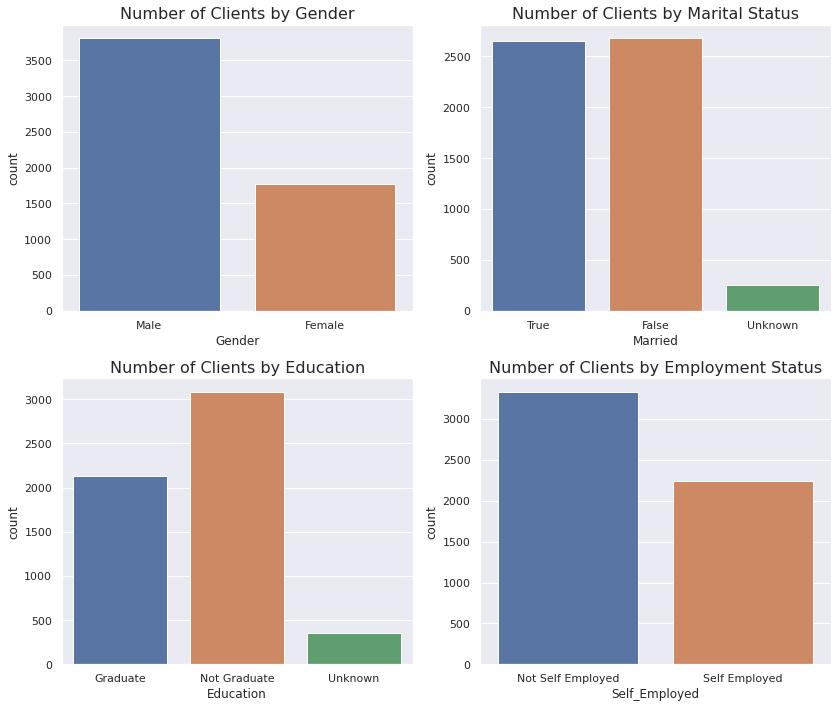

In [ ]:
sns.set_theme()
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,10))
ax = sns.countplot(data=loan_df, x='Gender', ax=axes[0,0])
ax.set_title('Number of Clients by Gender', fontsize=16)
ax2 = sns.countplot(data=loan_df, x='Married', ax=axes[0,1])
ax2.set_title('Number of Clients by Marital Status', fontsize=16)
ax3 = sns.countplot(data=loan_df, x='Education', ax=axes[1,0])
ax3.set_title('Number of Clients by Education', fontsize=16)
ax4 = sns.countplot(data=loan_df, x='Self_Employed', ax=axes[1,1])
ax4.set_title('Number of Clients by Employment Status', fontsize=16)
ax4.set(xticklabels=['Not Self Employed', 'Self Employed'])
fig.tight_layout()
plt.savefig('General information.png', dpi = 300);

In [ ]:
loan_df['Married'].value_counts()

False      2677
True       2650
Unknown     249
Name: Married, dtype: int64

In this graph we can see that majority of our clients are men (68%). 
We have almost the same number of clients by their maritul status.
More clients didn't graduate.
There are more self emploded clients.

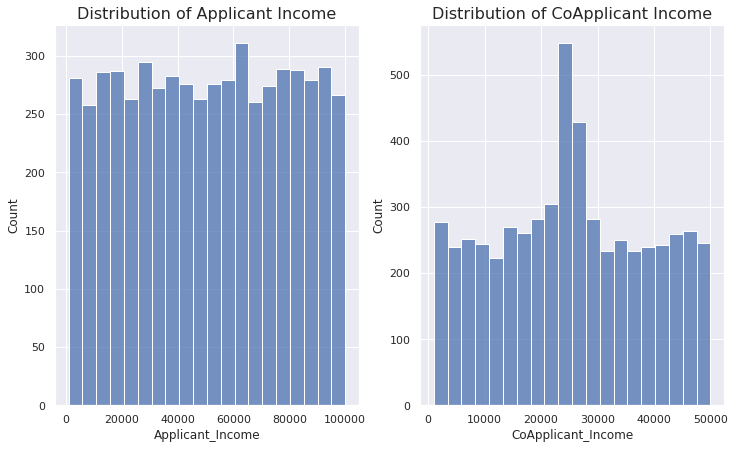

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12,7))
ax = sns.histplot(data=loan_df, x='Applicant_Income', bins=20, ax=axes[0])
ax.set_title('Distribution of Applicant Income', fontsize=16)
ax2 = sns.histplot(data=loan_df, x='CoApplicant_Income', bins=20, ax=axes[1])
ax2.set_title('Distribution of CoApplicant Income', fontsize=16);

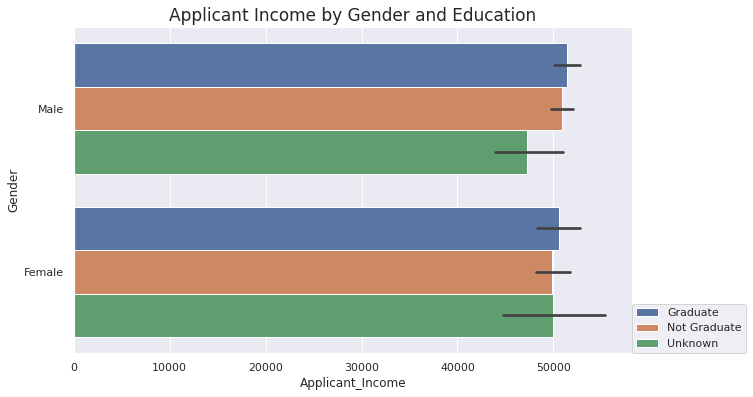

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=loan_df, x='Applicant_Income', y='Gender', hue='Education')
plt.title('Applicant Income by Gender and Education', fontsize=17)
plt.legend(loc=[1,0]);

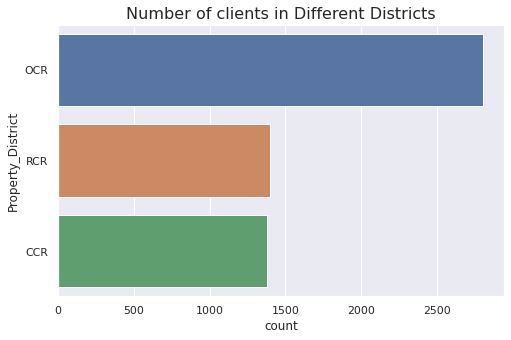

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=loan_df, y='Property_District')
plt.title('Number of clients in Different Districts',fontsize=16); 

Most of the clients live in a district OCR.

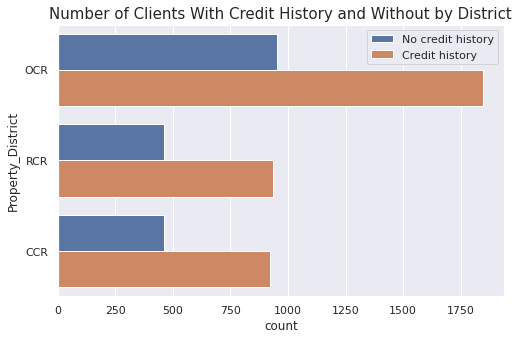

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=loan_df, y='Property_District', hue='Credit History') 
plt.legend(['No credit history', 'Credit history'])
plt.title('Number of Clients With Credit History and Without by District', fontsize=15);

Most of the client have a credit history.

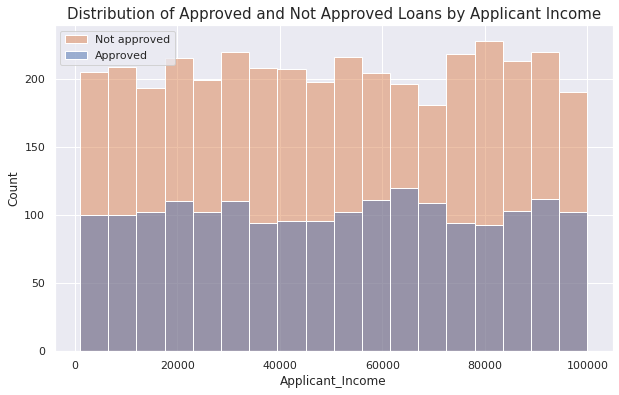

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(data=loan_df, x='Applicant_Income', hue='Loan_Status')
plt.legend(['Not approved', 'Approved'])
plt.title('Distribution of Approved and Not Approved Loans by Applicant Income', fontsize=15);

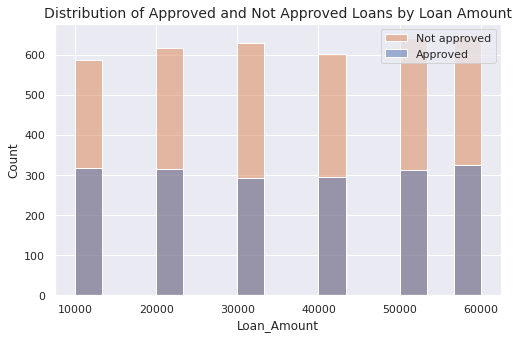

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(data=loan_df, x='Loan_Amount', hue='Loan_Status')
plt.legend(['Not approved', 'Approved'])
plt.title('Distribution of Approved and Not Approved Loans by Loan Amount', fontsize=14);

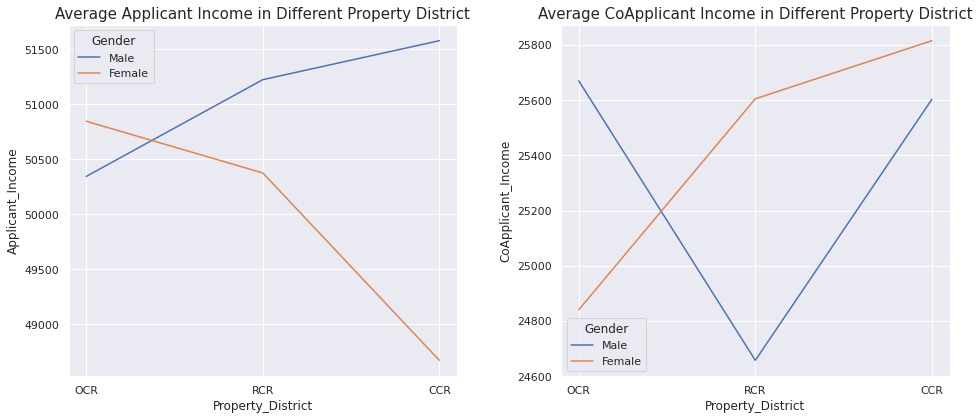

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14,6))
ax = sns.lineplot(x='Property_District', y='Applicant_Income', hue='Gender', data=loan_df, ci=None, ax=axes[0])
ax.set_title('Average Applicant Income in Different Property District', fontsize=15)
ax2 = sns.lineplot(x='Property_District', y='CoApplicant_Income', hue='Gender', data=loan_df, ci=None, ax=axes[1])
ax2.set_title('Average CoApplicant Income in Different Property District', fontsize=15)
fig.tight_layout()
plt.savefig('Average Applicant and CoApplicant income.png', dpi = 300);

## **Machine Learning**

## Prepare Data for fitting a Machine Learning Models

* Cleaning for Machine Learning

In [ ]:
#download data and check the head
loan_ml = pd.read_csv('/content/drive/MyDrive/Bootcamp/Data/partial_loan_dataset.csv')
loan_ml.head()

,Loan_ID,Gender,Married,Dependent_No,Education,Self_Employed,Applicant_Income,CoApplicant_Income,Loan_Amount,Loan_Amount_Term,Credit History,Property_District,Loan_Status
0,23002,Male,True,3,Graduate,True,4315,19748.0,60000,300,1,OCR,1
1,23003,Female,True,3,Not Graduate,True,3331,29657.0,20000,60,0,OCR,1
2,23004,Male,True,3,Not Graduate,True,22494,29539.0,30000,240,1,RCR,1
3,23005,Male,True,2,Not Graduate,False,78117,12909.0,20000,60,0,OCR,1
4,23006,Male,False,2,Not Graduate,False,41976,45598.0,60000,300,1,RCR,1


In [ ]:
#mape boolean columns for easie work later
repl_map = {'True':1, 'False':0}
loan_ml['Self_Employed'] = loan_ml['Self_Employed'].replace(repl_map)

In [ ]:
#change a type to ohe it later
loan_ml['Self_Employed'] = loan_ml['Self_Employed'].astype(str)

In [ ]:
#map columns type for easie work later
repl_map = {'True':1, 'False':0}
loan_ml['Married'] = loan_ml['Married'].replace(repl_map)

In [ ]:
#change a type to ohe it later
loan_ml['Married'] = loan_ml['Married'].astype(str)

In [ ]:
#drop rows that have 3 or more NaN values
loan_ml = loan_ml[loan_ml.isnull().sum(axis=1) < 3]

In [ ]:
#fill missing data in column 'Married' with 'Unknown'
married_missing = loan_ml['Married'].fillna('Unknown')

In [ ]:
loan_ml['Married'].fillna(value=married_missing, inplace=True)

In [ ]:
#fill missing data in column 'Education' with 'Unknown'
education_missing = loan_ml['Education'].fillna('Unknown')

In [ ]:
loan_ml['Education'].fillna(value=education_missing, inplace=True)

* Preparing Data for Machine Learning

In [ ]:
#check the class balance
loan_ml['Loan_Status'].value_counts(normalize=True)

1    0.667204
0    0.332796
Name: Loan_Status, dtype: float64

The target, Loan Status, is not balanced.

In [ ]:
#define features (X) and target (y)
X = loan_ml.drop(columns=['Loan_Status','Loan_ID'])
y = loan_ml['Loan_Status']

# split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=.25)

In [ ]:
#create selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [ ]:
#create imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')

#scaler and one-hot encoder
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [ ]:
#make numerical and categorical pipes
numeric_pipe = make_pipeline(mean_imputer, scaler)
categorical_pipe = make_pipeline(freq_imputer, ohe)

In [ ]:
#tuples for ColumnTransformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)

#instantiate ColumnTransformer
transformer = make_column_transformer(number_tuple, category_tuple,remainder="passthrough")
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f6de12d7a50>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f6de12d7fd0>)])

In [ ]:
#define a function that takes in arguments and prints out a classification report, confusion matrix and ROC AUC
def evaluate_classification(model, X_test, y_test, cmap=None,
                            normalize='true', classes=None, figsize=(20,5)):
  test_preds = model.predict(X_test)
  print(metrics.classification_report(y_test, test_preds, target_names=classes))

  fig, ax = plt.subplots(ncols=3, figsize=figsize)
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Greens',
                                        display_labels=classes,
                                        ax=ax[0])
  
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues',
                                        display_labels=classes, normalize='true',
                                        ax=ax[1])
  
  curve = metrics.plot_roc_curve(model, X_test, y_test, ax=ax[2])
  curve.ax_.grid()
  curve.ax_.plot([0, 1], [0, 1], ls=':')

## Logical Regression

In [ ]:
#instantiate Logistic Regression (default version of model with default hyperparameters)
logreg = LogisticRegression()

#make pipeline with model and transformer
logreg_pipe = make_pipeline(transformer, logreg)

# fit model and print scores
logreg_pipe.fit(X_train, y_train)

#evaluate the accuracy of the model with default settings and print
train_preds_log = logreg_pipe.predict(X_train)
test_preds_log = logreg_pipe.predict(X_test)

print('Logistic regression Train score:', accuracy_score(y_train, train_preds_log))
print('Logistic regression Test score:', accuracy_score(y_test, test_preds_log))

Logistic regression Train score: 0.6673035586338667
Logistic regression Test score: 0.6669054441260746


In [ ]:
#make a dictionary with parameters to tune the model
params = {'logisticregression__penalty':['l2','l1'], 
          'logisticregression__C':[0.0001, .001, .01, .1, 1, 10, 100], 
          'logisticregression__class_weight':[None, 'balanced'],
          'logisticregression__solver': ['liblinear']}

In [ ]:
#use GridSearchCV to find best parameters for the model
logreg_grid = GridSearchCV(logreg_pipe, params)

logreg_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f6de12d7a50>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          Sim...
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f6de12d7fd0>)])),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                                   10, 100],
                         'logisticregression__class_weight': [None, 'balanced'],
                         'logisticregression__penalty': ['l2', 'l1'],
                         'logisticregression__solver': ['liblinear']})

In [ ]:
#check best parameters for the model
logreg_grid.best_params_

{'logisticregression__C': 0.0001,
 'logisticregression__class_weight': None,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'liblinear'}

In [ ]:
#make the best version of the model from the gridsearch object
best_logreg = logreg_grid.best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       465
           1       0.67      1.00      0.80       931

    accuracy                           0.67      1396
   macro avg       0.33      0.50      0.40      1396
weighted avg       0.44      0.67      0.53      1396



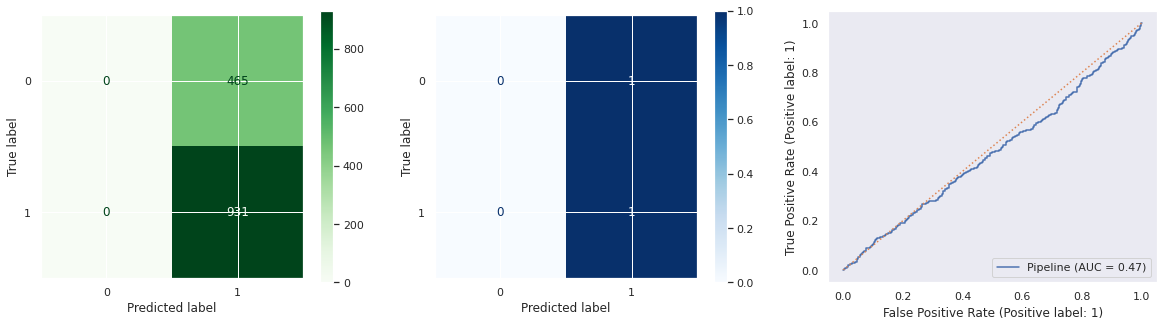

In [ ]:
#display a classification report, confusion matrix and ROC AUC for Logic Regression with best parameters 
evaluate_classification(best_logreg, X_test, y_test)

## KNN

In [ ]:
#instantiate KNN (default version of model with default hyperparameters)
knn = KNeighborsClassifier(n_neighbors=3)

#make pipeline with model and transformer
knn_pipe = make_pipeline(transformer, knn)

#fit model and print scores
knn_pipe.fit(X_train, y_train)

train_preds_knn = knn_pipe.predict(X_train)
test_preds_knn = knn_pipe.predict(X_test)

print('KNN train score:', accuracy_score(y_train, train_preds_knn))
print('KNN test score:', accuracy_score(y_test, test_preds_knn))

KNN train score: 0.7757344160496775
KNN test score: 0.579512893982808


In [ ]:
#make a dictionary with parameters to tune the model
params = {'kneighborsclassifier__n_neighbors': range(1,20,2),
          'kneighborsclassifier__weights': ['uniform', 'distance'],
          'kneighborsclassifier__p': [2, 3, 4]}

In [ ]:
#use GridSearchCV to find best parameters for the model
knn_grid = GridSearchCV(knn_pipe, params)

knn_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f6de12d7a50>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          Sim...
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f6de12d7fd0>)])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_neighbors=3))]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 20, 2),
                         'kneighborsclassifier__p': [2, 3, 4],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']})

In [ ]:
#check best parameters for the model
knn_grid.best_params_

{'kneighborsclassifier__n_neighbors': 19,
 'kneighborsclassifier__p': 4,
 'kneighborsclassifier__weights': 'uniform'}

In [ ]:
#make the best version of the model from the gridsearch object
best_knn = knn_grid.best_estimator_

              precision    recall  f1-score   support

           0       0.33      0.06      0.10       465
           1       0.67      0.94      0.78       931

    accuracy                           0.65      1396
   macro avg       0.50      0.50      0.44      1396
weighted avg       0.55      0.65      0.55      1396



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


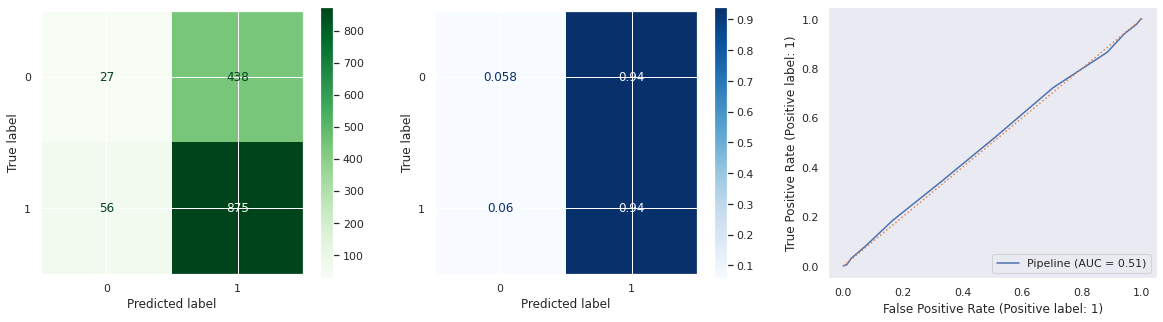

In [ ]:
#display a classification report, confusion matrix and ROC AUC for KNN with best parameters 
evaluate_classification(best_knn, X_test, y_test)

## Random Forest

In [ ]:
#instantiate Random Forest (default version of model with default hyperparameters)
rf = RandomForestClassifier()

#make pipeline with model and transformer
rf_pipe = make_pipeline(transformer, rf)

# fit model and print scores
rf_pipe.fit(X_train, y_train)

train_preds_rf = rf_pipe.predict(X_train)
test_preds_rf = rf_pipe.predict(X_test)

print('Random Forest train score:', accuracy_score(y_train, train_preds_rf))
print('Random Forest test score:', accuracy_score(y_test, test_preds_rf))

Random Forest train score: 1.0
Random Forest test score: 0.6404011461318052


In [ ]:
#make a dictionary with parameters to tune the model
params = {'randomforestclassifier__max_depth': range(1, 10),
          'randomforestclassifier__max_features': ['auto', 'sqrt'],
          'randomforestclassifier__min_samples_leaf':[1, 2, 4],
          'randomforestclassifier__n_estimators': [100, 200,],
          'randomforestclassifier__class_weight':['balanced','balanced_subsample']}

In [ ]:
#use GridSearchCV to find best parameters for the model
rf_grid = GridSearchCV(rf_pipe, params)

rf_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f6de12d7a50>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          Sim...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f6de12d7fd0>)])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__class_weight': ['balanced',
                                                                  'balanced_subsample'],
                         'randomforestclassifier__max_depth': range(1, 10),
                         'randomforestclassifier__max_features': ['auto',
                                                                  'sqrt'],
                         'randomforestclassifier__min_samples_leaf': [1, 2, 4],
                         'randomforestclassifier__n_estimators': [100, 200]})

In [ ]:
#check best parameters for the model
rf_grid.best_params_

{'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__max_depth': 9,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__n_estimators': 200}

In [ ]:
#make the best version of the model from the gridsearch object
best_rf = rf_grid.best_estimator_

              precision    recall  f1-score   support

           0       0.34      0.27      0.30       465
           1       0.67      0.73      0.70       931

    accuracy                           0.58      1396
   macro avg       0.50      0.50      0.50      1396
weighted avg       0.56      0.58      0.57      1396



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


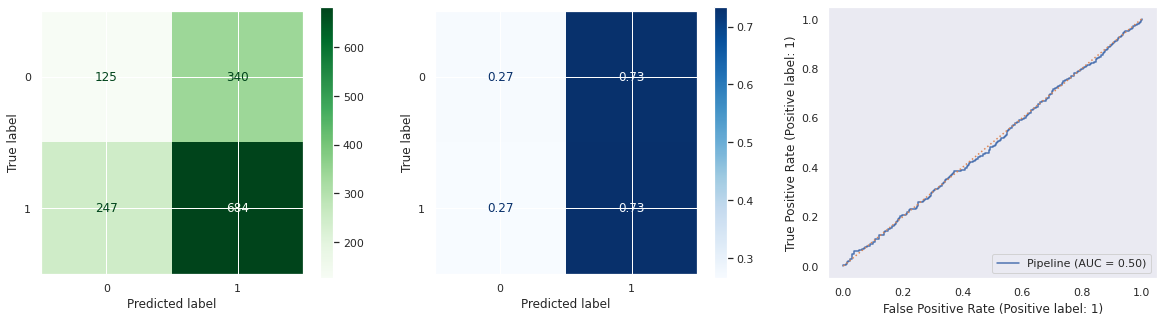

In [ ]:
#display a classification report, confusion matrix and ROC AUC for Random Forest with best parameters 
evaluate_classification(best_rf, X_test, y_test)

## **LGBM Classifier**

              precision    recall  f1-score   support

           0       0.30      0.09      0.14       465
           1       0.66      0.90      0.76       931

    accuracy                           0.63      1396
   macro avg       0.48      0.49      0.45      1396
weighted avg       0.54      0.63      0.55      1396



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


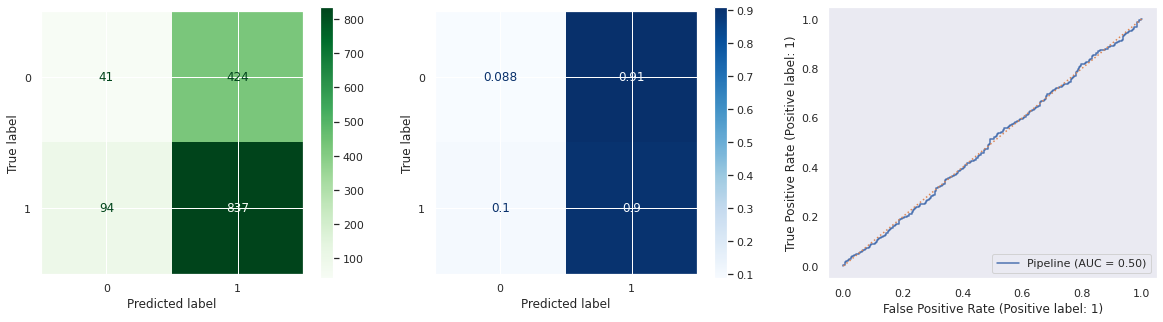

In [ ]:
lgb_pipe = make_pipeline(transformer, LGBMClassifier())

lgb_pipe.fit(X_train, y_train)

evaluate_classification(lgb_pipe, X_test, y_test)

In [ ]:
#make a function to compare accuracy
def compare_model_scores(model, X_train,X_test, y_train, y_test, scoring='accuracy', model_name='Classifier'):
  
  #get scorer and evaluate model
  scoring_func = get_scorer(scoring)
  train_score = scoring_func(model, X_train, y_train)
  test_score = scoring_func(model, X_test, y_test)

  #get difference
  delta_score = test_score - train_score

  score_dict = {f'{scoring}: training': train_score,
                f'{scoring}: testing': test_score,
                f'{scoring}: delta': delta_score}
  
  score_frame = pd.DataFrame(score_dict, index=[model_name])
  
  return score_frame

In [ ]:
#make report for each model and concatenate
model_report = compare_model_scores(best_logreg, X_train, X_test, y_train, y_test, model_name='LogisticRegression')
knn_report = compare_model_scores(best_knn, X_train, X_test, y_train, y_test, model_name='KNeighborsClassifier')
rf_report = compare_model_scores(best_rf, X_train, X_test, y_train, y_test, model_name='RandomForestClassifier')
lgb_report = compare_model_scores(lgb_pipe, X_train, X_test, y_train, y_test, model_name='LGBMClassifier')
model_report = model_report.append([knn_report, rf_report,lgb_report])

In [ ]:
#print metrics for all models
print('Best Result for Logical Regression:')
print(classification_report(y_test,best_logreg.predict(X_test)))
print('Best Result for KNN:')
print(classification_report(y_test,best_knn.predict(X_test)))
print('Best Result for Random Forest:')
print(classification_report(y_test,best_rf.predict(X_test)))
print('Best Result for LGBM:')
print(classification_report(y_test,lgb_pipe.predict(X_test)))
model_report

Best Result for Logical Regression:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       465
           1       0.67      1.00      0.80       931

    accuracy                           0.67      1396
   macro avg       0.33      0.50      0.40      1396
weighted avg       0.44      0.67      0.53      1396

Best Result for KNN:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.33      0.06      0.10       465
           1       0.67      0.94      0.78       931

    accuracy                           0.65      1396
   macro avg       0.50      0.50      0.44      1396
weighted avg       0.55      0.65      0.55      1396

Best Result for Random Forest:
              precision    recall  f1-score   support

           0       0.34      0.27      0.30       465
           1       0.67      0.73      0.70       931

    accuracy                           0.58      1396
   macro avg       0.50      0.50      0.50      1396
weighted avg       0.56      0.58      0.57      1396

Best Result for LGBM:
              precision    recall  f1-score   support

           0       0.30      0.09      0.14       465
           1       0.66      0.90      0.76       931

    accuracy                           0.63      1396
   macro avg       0.48      0.49      0.45      1396
weighted avg       0.

,accuracy: training,accuracy: testing,accuracy: delta
LogisticRegression,0.667304,0.666905,-0.000398
KNeighborsClassifier,0.667781,0.646132,-0.021649
RandomForestClassifier,0.897779,0.579513,-0.318266
LGBMClassifier,0.807261,0.628940,-0.178321


* For my project I tried many classification models. Here I'm comparing results of 4 models: Logical Regression, KNN, Random Forest and LGBM Classifier. If we compare acuraccy for testing set we can see that best results has Logical Regression Model (67%), but this model doesn't predict class 0 at all. That is the reason why I decided to use Random Forest as my Model. Acuraccy of this model is 58%, but this model predicts class 0 better than other models, 26% of class 0 and 74% of class 1 are predicted. 